* Автор: Cташ Амир Рамазанович
* Телеграм: svoenravn500

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.decomposition import PCA
import optuna

### Загрузка данных

In [2]:
train = pd.read_csv('../input/amur-hack-2022/train_dataset_train (1).csv')
test = pd.read_csv('../input/amur-hack-2022/test_dataset_test (1).csv')
submission = pd.read_csv('../input/amur-hack-2022/sample_solution.csv')

In [4]:
def downcastMemoryUsage(dataFrame):
    startMemoryOptimization = dataFrame.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is: \033[1m{:.2f} MB\033[0m'.format(startMemoryOptimization))
    subTypeInt = ['uint8','uint16','uint32','uint64','int8','int16','int32','int64']
    subTypeFloat = ['float16','float32','float64']
    for column in dataFrame.columns:
        columnType = str(dataFrame[column].dtypes)
        maximumColumn = dataFrame[column].max()
        minimumColumn = dataFrame[column].min()
        if 'int' in columnType:
            for element in subTypeInt:
                if minimumColumn > np.iinfo(element).min and maximumColumn < np.iinfo(element).max:
                    dataFrame[column] = dataFrame[column].astype(element)
                    break
        elif 'float' in columnType:
            for element in subTypeFloat:
                if minimumColumn > np.finfo(element).min and maximumColumn < np.finfo(element).max:
                    dataFrame[column] = dataFrame[column].astype(element)
                    break
        elif 'object' in columnType:
            numberOfUnique = len(dataFrame[column].unique())
            numberOfTotal = len(dataFrame[column])
            if numberOfUnique / numberOfTotal < 0.5:
                dataFrame[column] = dataFrame[column].astype('category')
    endMemoryOptimization = dataFrame.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: \033[1m{:.2f} MB\033[0m'.format(endMemoryOptimization))
    print('Compressed by: \033[1m{:.2f} %\033[0m'.format(100*(startMemoryOptimization - endMemoryOptimization) / startMemoryOptimization))
    return dataFrame

In [5]:
train = downcastMemoryUsage(train)
test = downcastMemoryUsage(test)

Memory usage of dataframe is: 99.89 MB
Memory usage after optimization is: 53.24 MB
Compressed by: 46.70 %
Memory usage of dataframe is: 42.87 MB
Memory usage after optimization is: 28.59 MB
Compressed by: 33.31 %


### Получение геоданных из api.hh.ru 

In [6]:
# https://api.hh.ru/metro/1
metro = pd.read_json('../input/amur-hack-2022/city_data/metro.json', encoding='cp1251')

station_list = []

for line in (metro['lines']):
    for station in line['stations']:
        station_list.append([station['name'], station['lat'], station['lng']])
        
metro_df = pd.DataFrame(station_list, columns=['name', 'lat', 'lng'])
metro_df = metro_df.rename(columns = {"name": "station_nm"})

In [10]:
metro_df

,station_nm,lat,lng
0,Новокосино,55.745113,37.864052
1,Новогиреево,55.752237,37.814587
2,Перово,55.750980,37.784220
3,Шоссе Энтузиастов,55.758090,37.751703
4,Авиамоторная,55.751933,37.717444
...,...,...,...
344,Остафьево,55.503370,37.520055
345,Силикатная,55.470278,37.555278
346,Подольск,55.431667,37.565000
347,Трикотажная,55.833137,37.398967


### функции для получения новых признаков

In [7]:
def make_harmonic_features(value, period=24):
    value *= 2 * np.pi / period
    return np.cos(value), np.sin(value)

def baseline_time_feature(df):
    df['pass_dttm'] = pd.to_datetime(df['pass_dttm'])
    df['month'] = df.pass_dttm.dt.month.astype("int8")
    df['day'] = df.pass_dttm.dt.day.astype('int8')
    df['hour'] = df.pass_dttm.dt.hour.astype('int8')
    df['minute'] = df.pass_dttm.dt.minute.astype('int8')
    df['second'] = df.pass_dttm.dt.second.astype('int8')
    df['year'] = df.pass_dttm.dt.year.astype("int32")
    df['moment']  = df['pass_dttm'].dt.hour * 6 + df['pass_dttm'].dt.minute // 10
    df['weekday'] = df.pass_dttm.dt.weekday
    df['week_day_cos'] = df['weekday'].apply(lambda x: make_harmonic_features(x, 7)[0])
    df['week_day_sin'] = df['weekday'].apply(lambda x: make_harmonic_features(x, 7)[1])
    df['hour_cos'] = df['hour'].apply(lambda x: make_harmonic_features(x, 24)[0])
    df['hour_sin'] = df['hour'].apply(lambda x: make_harmonic_features(x, 24)[1])
    
    
    return df



def enocode_categorical_features(df, cols):
    encoder = df.groupby(cols).size()/len(df)
    df.loc[:, cols + '_encode'] = df[cols].map(encoder)
    return df

def rotation(data):
    data['rot_45_lng'] = (0.707 * data['lng']) + (0.707 * data['lat'])
    data['rot_45_lng'] = (0.707 * data['lat']) + (0.707 * data['lng'])
    data['rot_30_lng'] = (0.866 * data['lng']) + (0.5 * data['lat'])
    data['rot_30_lng'] = (0.866 * data['lat']) + (0.5 * data['lng'])
    return data

def pca(data):
    coordinates = data[['lng','lat']].values
    pca_obj = PCA().fit(coordinates)
    data['pca_lng'] = pca_obj.transform(data[['lng', 'lat']])[:,0]
    data['pca_lat'] = pca_obj.transform(data[['lng', 'lat']])[:,1]
    return data


### Получение и обработка признаков

In [8]:
train = baseline_time_feature(train)
test = baseline_time_feature(test)

train = pd.merge(train, metro_df , on="station_nm", how='left').drop_duplicates(subset="id")
test = pd.merge(test, metro_df , on="station_nm", how='left').drop_duplicates(subset="id")

train['lat'] = train['lat'].fillna(train['lat'].mean())
train['lng'] = train['lng'].fillna(train['lng'].mean())


test['lat'] = test['lat'].fillna(test['lat'].mean())
test['lng'] = test['lng'].fillna(test['lng'].mean())

train = rotation(train)
test = rotation(test)

train = pca(train)
test = pca(test)

train['dif_max_lng'] =  (train['lng'].max() - train['lng'])
test['dif_max_lng'] =  (test['lng'].max() - test['lng'])

train['dif_max_lng'] =  (train['lat'].max() - train['lat'])
test['dif_max_lng'] =  (test['lat'].max() - test['lat'])

train['dif_min_lat'] =  (train['lat'].min() - train['lat'])
test['dif_min_lat'] =  (test['lat'].min() - test['lat'])

train['dif_max_lng'] =  (train['lng'].max() - train['lng'])
test['dif_max_lng'] =  (test['lng'].max() - test['lng'])

train['dif_mean_lng'] =  (train['lng'].mean() - train['lng'])
test['dif_mean_lng'] =  (test['lng'].mean() - test['lng'])

train['dif_mean_lat'] =  (train['lat'].mean() - train['lat'])
test['dif_mean_lat'] =  (test['lat'].mean() - test['lat'])

train['circle_lat_lng'] = (train['lat']* train['lat']) + (train['lng']*train['lng'])
test['circle_lat_lng'] = (test['lat']* test['lat']) + (test['lng']*test['lng'])

train['circle_lat_lng_max'] = (train['lat'].max()* train['lat'].max()) + (train['lng'].max()*train['lng'].max())
test['circle_lat_lng_max'] = (test['lat'].max()* test['lat'].max()) + (test['lng'].max()*test['lng'].max())

train['circle_lat_lng_min'] = (train['lat'].min()* train['lat'].min()) + (train['lng'].min()*train['lng'].min())
test['circle_lat_lng_min'] = (test['lat'].min()* test['lat'].min()) + (test['lng'].min()*test['lng'].min())

train['circle_lat_lng_mean'] = (train['lat'].mean()* train['lat'].mean()) + (train['lng'].mean()*train['lng'].mean())
test['circle_lat_lng_mean'] = (test['lat'].mean()* test['lat'].mean()) + (test['lng'].mean()*test['lng'].mean())

train['circle_diff_min'] = train['circle_lat_lng_min'] - train['circle_lat_lng']
test['circle_diff_min'] = test['circle_lat_lng_min'] - test['circle_lat_lng']

train['circle_diff_max'] = train['circle_lat_lng_max'] - train['circle_lat_lng']
test['circle_diff_max'] = test['circle_lat_lng_max'] - test['circle_lat_lng']

train['circle_diff_mean'] = train['circle_lat_lng_mean'] - train['circle_lat_lng']
test['circle_diff_mean'] = test['circle_lat_lng_mean'] - test['circle_lat_lng']


train = train.drop('pass_dttm' , axis = 1)
test = test.drop('pass_dttm', axis = 1)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [9]:
train = train[train['label'] < 40000]

In [10]:
train['ticket_entrance_count'] = train[['entrance_id','ticket_type_nm']].groupby('entrance_id', as_index=False).transform('count')
test['ticket_entrance_count'] = test[['entrance_id','ticket_type_nm']].groupby('entrance_id', as_index=False).transform('count')

train['moment_station_count'] = train[['station_id','moment']].groupby('station_id', as_index=False).transform('count')
test['moment_station_count'] = test[['station_id','moment']].groupby('station_id', as_index=False).transform('count')

train['day_moment_count'] = train[['day','moment']].groupby('day', as_index=False).transform('count')
test['day_moment_count'] = test[['day','moment']].groupby('day', as_index=False).transform('count')

train['line_moment_count'] = train[['line_nm','moment']].groupby('line_nm', as_index=False).transform('count')
test['line_moment_count'] = test[['line_nm','moment']].groupby('line_nm', as_index=False).transform('count')

train['ticket_month_count'] = train[['month','ticket_type_nm']].groupby('month', as_index=False).transform('count')
test['ticket_month_count'] = test[['month','ticket_type_nm']].groupby('month', as_index=False).transform('count')



train['ticket_entrance_count'] = train[['entrance_id','ticket_type_nm']].groupby('entrance_id', as_index=False).transform('count')
test['ticket_entrance_count'] = test[['entrance_id','ticket_type_nm']].groupby('entrance_id', as_index=False).transform('count')

In [11]:
cat_features = ['ticket_type_nm' , 'entrance_nm' , 'line_nm' , 'station_nm'] 

for cols in cat_features:
    train = enocode_categorical_features(train,cols)
    test = enocode_categorical_features(test,cols)

train = train.drop(cat_features,axis = 1)
test = test.drop(cat_features,axis = 1)
train['line_nm_encode'] = train['line_nm_encode'].astype('float64')
test['line_nm_encode'] = test['line_nm_encode'].astype('float64')

### Разделение данных на X,y

In [12]:
X = train.drop(["ticket_id",'id',"label","time_to_under"], axis = 1)
y = train[["time_to_under", "label"]]

In [13]:
y_label = y['label']
y_time = y['time_to_under']

In [14]:
test = test[X.columns]

In [15]:
from sklearn.metrics import recall_score , r2_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

### Стратификация для задачи регрессии

### label


In [22]:
train['label_strat'], bin_edges = pd.qcut(y_label, q=3, labels=False, retbins=True, precision=0)

X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.3 , shuffle=True,
                                                    random_state=512, stratify = train['label_strat'])

smote = RandomOverSampler(random_state=512)
X_train , y_train = smote.fit_resample(X_train,y_train)

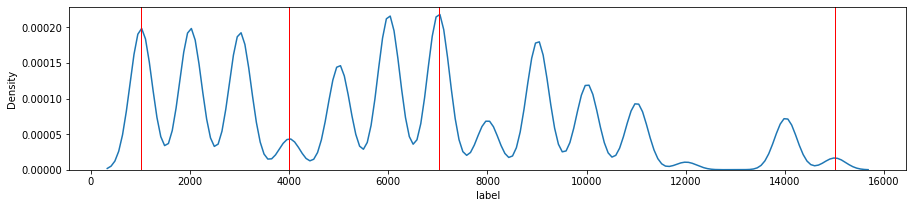

In [16]:
plt.figure(figsize=(15,3))
sns.kdeplot(y_label);
for v_line in bin_edges:
    plt.axvline(v_line, c='red', linewidth=1);

### Catboost Tuning

In [16]:
def objective(trial):
    train['label_strat'], bin_edges = pd.qcut(y_label, q=3, labels=False, retbins=True, precision=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.3 , shuffle=True,
                                                    random_state=512, stratify = train['label_strat'])

    smote = RandomOverSampler(random_state=512)
    X_train , y_train = smote.fit_resample(X_train,y_train)
    param = {
        'verbose' : False,
        'task_type' : 'GPU',
        'random_strength' : trial.suggest_float('random_strength', 0.2 ,1),
        'bagging_temperature' : trial.suggest_loguniform('bagging_temperature' , 1e-1 , 1),
        "iterations": trial.suggest_int("iterations", 3500,  8500 , 500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'max_bin': trial.suggest_int('max_bin', 200, 400),
    }
    
    model = CatBoostRegressor(**param)
    model.fit(X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            use_best_model = True,
        )
    score = recall_score(y_test,model.predict(X_test).round().astype(int), average='macro')
    
    return score

In [17]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-11-20 20:03:26,574] A new study created in memory with name: no-name-f5ee7e1c-6229-45ac-8932-3854505e425b
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if sys.path[0] == "":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 

Number of finished trials: 10
Best trial: {'random_strength': 0.7117247232048882, 'bagging_temperature': 0.7852272717997959, 'iterations': 8000, 'learning_rate': 0.09068514099426275, 'max_depth': 12, 'l2_leaf_reg': 0.20582876685513998, 'max_bin': 300}


In [18]:
params_cat = study.best_params

In [18]:
params_cat = {'random_strength': 0.7117247232048882,
 'bagging_temperature': 0.7852272717997959,
 'iterations': 8000,
 'learning_rate': 0.09068514099426275,
 'max_depth': 12,
 'l2_leaf_reg': 0.20582876685513998,
 'max_bin': 300}

### Обучение CatBoost моделей

In [19]:
models_cat = []
train['label_strat'], bin_edges = pd.qcut(y_label, q=3, labels=False, retbins=True, precision=0)
kFold_random_state = [101, 42, 666, 228, 777, 2021, 75 , 869 ,1370 , 1750, 2142 ,3657]
for ind_k, random_state in enumerate(kFold_random_state):
        X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.3 , shuffle=True,
                                           random_state=random_state,
                                           stratify = train['label_strat'])
        smote = RandomOverSampler(random_state=512)
        X_train , y_train = smote.fit_resample(X_train,y_train)
        
        model = CatBoostRegressor(**params_cat , task_type = 'GPU' , 
                                  random_seed= random_state , early_stopping_rounds= 250 + ind_k*10)
        
        model.fit(X_train, y_train, eval_set=(X_test, y_test),
                verbose=500, use_best_model = True, plot=False)
        
        score = recall_score(y_test,model.predict(X_test).round().astype(int),
                             average='macro')
        print(score)
        models_cat.append(model)

0:	learn: 4181.3968808	test: 3790.0180239	best: 3790.0180239 (0)	total: 63ms	remaining: 8m 23s
bestTest = 3261.827273
bestIteration = 179
Shrink model to first 180 iterations.


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.838337615261529e-06
0:	learn: 4183.0191808	test: 3787.9448955	best: 3787.9448955 (0)	total: 58.1ms	remaining: 7m 44s
500:	learn: 2917.0205584	test: 3264.8790786	best: 3258.6423681 (285)	total: 32.3s	remaining: 8m 4s
bestTest = 3258.642368
bestIteration = 285
Shrink model to first 286 iterations.


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2.8554964996452766e-06
0:	learn: 4182.9242008	test: 3793.5818803	best: 3793.5818803 (0)	total: 60.1ms	remaining: 8m
bestTest = 3260.21234
bestIteration = 220
Shrink model to first 221 iterations.


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4.893204798880536e-06
0:	learn: 4182.1374455	test: 3792.8857081	best: 3792.8857081 (0)	total: 66.1ms	remaining: 8m 48s
500:	learn: 2911.4800217	test: 3264.2380722	best: 3258.3547114 (253)	total: 33.8s	remaining: 8m 26s
bestTest = 3258.354711
bestIteration = 253
Shrink model to first 254 iterations.


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.7594683159080255e-05
0:	learn: 4182.4728196	test: 3789.2866009	best: 3789.2866009 (0)	total: 65.8ms	remaining: 8m 46s
500:	learn: 2918.1271498	test: 3260.0871821	best: 3254.4201420 (222)	total: 33s	remaining: 8m 13s
bestTest = 3254.420142
bestIteration = 222
Shrink model to first 223 iterations.


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2.346655743904684e-06
0:	learn: 4182.3421323	test: 3788.7998443	best: 3788.7998443 (0)	total: 58.2ms	remaining: 7m 45s
500:	learn: 2910.9871087	test: 3266.6154884	best: 3260.6321362 (262)	total: 34.5s	remaining: 8m 35s
bestTest = 3260.632136
bestIteration = 262
Shrink model to first 263 iterations.


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2.269457253129211e-06
0:	learn: 4182.8529702	test: 3787.7919663	best: 3787.7919663 (0)	total: 62.8ms	remaining: 8m 22s
500:	learn: 2918.3738542	test: 3257.5813825	best: 3251.3386115 (239)	total: 34.1s	remaining: 8m 29s
bestTest = 3251.338612
bestIteration = 239
Shrink model to first 240 iterations.


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3.6338256834397252e-06
0:	learn: 4183.8164280	test: 3788.9670050	best: 3788.9670050 (0)	total: 63.1ms	remaining: 8m 24s
500:	learn: 2916.4963852	test: 3261.7043126	best: 3254.7112932 (204)	total: 33.3s	remaining: 8m 18s
bestTest = 3254.711293
bestIteration = 204
Shrink model to first 205 iterations.


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3.1181946615900153e-06
0:	learn: 4182.6854696	test: 3790.0119707	best: 3790.0119707 (0)	total: 61.9ms	remaining: 8m 15s
500:	learn: 2917.1584585	test: 3262.9918405	best: 3256.0758195 (245)	total: 32.3s	remaining: 8m 3s
bestTest = 3256.07582
bestIteration = 245
Shrink model to first 246 iterations.


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8.463242025288413e-06
0:	learn: 4182.1189928	test: 3788.6112661	best: 3788.6112661 (0)	total: 61.9ms	remaining: 8m 15s
500:	learn: 2907.7327444	test: 3267.7186740	best: 3260.6301259 (239)	total: 32.9s	remaining: 8m 11s
bestTest = 3260.630126
bestIteration = 239
Shrink model to first 240 iterations.


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2.2837233251026782e-06
0:	learn: 4182.6226247	test: 3786.3904404	best: 3786.3904404 (0)	total: 60.6ms	remaining: 8m 4s
500:	learn: 2915.8848672	test: 3256.0945663	best: 3250.3155750 (253)	total: 33.1s	remaining: 8m 15s
bestTest = 3250.315575
bestIteration = 253
Shrink model to first 254 iterations.


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.8625285534273786e-06
0:	learn: 4182.8793168	test: 3791.1737865	best: 3791.1737865 (0)	total: 66.1ms	remaining: 8m 49s
500:	learn: 2923.1780413	test: 3264.8403056	best: 3258.1959110 (253)	total: 37.6s	remaining: 9m 23s
bestTest = 3258.195911
bestIteration = 253
Shrink model to first 254 iterations.
2.1926101428044235e-06


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
y_pred_cat = np.zeros((len(test),))
scores = []
for model in models_cat:
    y_pred_cat += model.predict(test).round().astype(int)
y_pred_cat /= len(models_cat)
y_pred_cat = y_pred_cat.astype(int)

In [ ]:
y_pred_x = np.zeros((len(X_test),))
scores = []
for model in models_cat:
    y_pred_cat += model.predict(X_test).round().astype(int)
y_pred_x /= len(models_cat)
y_pred_x = y_pred_x.astype(int)

### time

In [31]:
train['time_strat'], bin_edges = pd.qcut(y_time, q=3, labels=False, retbins=True, precision=0)

X_train, X_test, y_train, y_test = train_test_split(X, y_time, test_size=0.3 , shuffle=True,
                                                    random_state=512, stratify = train['time_strat'])


In [32]:
reg  = CatBoostRegressor(task_type = 'GPU' , n_estimators= 6500 , verbose = False)
reg.fit(X_train, y_train)

In [33]:
pred_reg = reg.predict(X_test)
r2_score(y_test , pred_reg)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_regression.py:807: RuntimeWarning: overflow encountered in square
  weight * (y_true - np.average(y_true, axis=0, weights=sample_weight)) ** 2


1.0

### Score

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3 , shuffle=True,  random_state=512)

In [30]:
from sklearn.metrics import recall_score, r2_score


score = 0.5 * recall_score(y_test["label"], y_pred_x , average='macro') +  0.5 * r2_score(y_test["time_to_under"], pred_reg)
score

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_regression.py:807: RuntimeWarning: overflow encountered in square
  weight * (y_true - np.average(y_true, axis=0, weights=sample_weight)) ** 2


0.5000107843300609

In [34]:
y_pred = y_pred_cat
pred_reg = reg.predict(test)

In [37]:
submission['time_to_under'] = abs(pred_reg)
submission['label'] = y_pred

In [38]:
submission

,id,time_to_under,label
0,1091022,547.025059,5837
1,1091023,209.090734,5329
2,1091024,449.101517,5834
3,1091025,565.701221,5594
4,1091026,542.818506,5257
...,...,...,...
561885,1652907,109.457631,6843
561886,1652908,3.063253,9594
561887,1652909,30.567002,3385
561888,1652910,19.523218,6478


In [40]:
submission.to_csv('cat_12_seed.csv', index = False)